# **Inner Evaluation: Kmeans**

## **Requirements**

In [2]:
import polars as pl
import pandas as pd
import numpy as np
import sys
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from  xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('whitegrid')

In [18]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\PyML_Package_Private')
from PyML.preprocessing import encoder, imputer, scaler, features_selector
from PyML.evaluation import SimpleEvaluation


In [19]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\Packages\FastKmedoids_Package_Private')
from FastKmedoids.data import sort_predictors_for_GG
from FastKmedoids.models import KmeansEstimator

## **Data**

In [20]:
madrid_houses_df = pl.read_csv('Data/madrid_houses_NaNS.csv')
variables_to_remove = ['', 'id', 'district', 'neighborhood', 'sq_mt_allotment']
variables_to_keep = [x for x in madrid_houses_df.columns if x not in variables_to_remove]
madrid_houses_df = madrid_houses_df[variables_to_keep]
madrid_houses_df.head()

sq_mt_built,n_rooms,n_bathrooms,n_floors,floor,buy_price,is_renewal_needed,has_lift,is_exterior,energy_certificate,has_parking,house_type
f64,i64,i64,i64,i64,i64,bool,bool,bool,i64,bool,i64
64.0,2,1,1,3,85000,false,false,true,4,false,1
70.0,3,1,1,4,129900,true,true,true,0,false,1
94.0,2,2,1,1,144247,false,true,true,0,false,1
64.0,2,1,1,-1,109900,false,true,true,0,false,1
108.0,2,2,1,4,260000,false,true,true,0,true,1


In [21]:
quant_columns = ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'n_floors', 'buy_price']
cat_columns = [x for x in madrid_houses_df.columns if x not in quant_columns]

response = 'buy_price'
quant_predictors = [x for x in quant_columns if x != response]
cat_predictors = [x for x in cat_columns if x != response]
predictors = quant_predictors + cat_predictors

In [22]:
cat_predictors_sorted, p1, p2, p3 = sort_predictors_for_GG(df=madrid_houses_df, quant_predictors=quant_predictors, cat_predictors=cat_predictors)

## **Response and Predictors**

In [23]:
Y = madrid_houses_df[response].to_pandas()
X = madrid_houses_df[predictors].to_pandas()
# The Null values of the Polars columns that are define as Object type by Pandas are treated as None and not as NaN (what we would like)
# The avoid this behavior the next step is necessary
X = X.fillna(value=np.nan)

## **Defining outer evaluation: train-test split**


In [24]:
# Defining the outer-evaluation: train-test split.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.90, random_state=123)
# We set a large train size since we are mainly interested in compare models not in estimating the feature performance (indeed, we could omit the test part and doing the inner eval. with the whole data)

## **Defining inner evaluation: K-Fold Cross Validation**

In [25]:
# Defining the inner-evaluation: K-fold cross validation
inner = KFold(n_splits=4, shuffle=True, random_state=111)

In [66]:
inner_score, best_params, inner_results = {}, {}, {}

## Example of usage

In [27]:
quant_pipeline = Pipeline([('imputer', imputer(apply=True, method='iterative_median'))])

cat_pipeline = Pipeline([('encoder', encoder(method='ordinal')),
                         ('imputer', imputer(apply=True, method='simple_most_frequent'))])

quant_cat_transformer = ColumnTransformer(transformers=[('quant', quant_pipeline, quant_predictors),
                                                        ('cat', cat_pipeline, cat_predictors_sorted)])

In [28]:
# Defining estimators to be used in each cluster
estimators_RF_XGB_2_clusters = {0: RandomForestRegressor(random_state=123),
                                1: XGBRegressor(random_state=123)}

In [29]:
X_train = quant_cat_transformer.fit_transform(X_train)
X_test = quant_cat_transformer.transform(X_test)
X_train = pd.DataFrame(X_train, columns=quant_predictors + cat_predictors_sorted)
X_test = pd.DataFrame(X_test, columns=quant_predictors + cat_predictors_sorted)

In [30]:
kmeans_regressor = KmeansEstimator(estimators=estimators_RF_XGB_2_clusters, 
                                   n_clusters=2, random_state=123)

In [31]:
kmeans_regressor.fit(X=X_train, y=Y_train)
Y_test_hat = kmeans_regressor.predict(X_test)
mean_absolute_error(y_pred=Y_test_hat, y_true=Y_test)

Clusters weights (proportions): [0.88366982 0.11633018]


189485.72342915318

## **Pipelines definition**

In [32]:
quant_pipeline = Pipeline([('imputer', imputer(apply=True)),
                           ('scaler', scaler())
                          ])

cat_pipeline = Pipeline([('encoder', encoder(method='ordinal')),
                         ('imputer', imputer(apply=True))
                        ])

quant_cat_preprocessing = ColumnTransformer(transformers=[('quant', quant_pipeline, quant_predictors),
                                                          ('cat', cat_pipeline, cat_predictors_sorted)]) 

In [33]:
meta_models = {'XGB': XGBRegressor(random_state=123),
               'RF': RandomForestRegressor(random_state=123)}

clusters_RF = [0,2,4,6]
clusters_XGB = [1,3,5,7]
max_n_clusters = len(clusters_RF + clusters_XGB)

estimators_RF_XGB = {j: meta_models['RF'] for j in clusters_RF}
estimators_RF_XGB.update({j: meta_models['XGB'] for j in clusters_XGB}) 

clustering_estimator = KmeansEstimator(estimators=estimators_RF_XGB, 
                                       n_clusters=2)

pipeline_clustering_model = Pipeline([('preprocessing', quant_cat_preprocessing),
                                      ('features_selector', features_selector()),
                                      ('clustering_model', clustering_estimator)
                                     ]) 

## **Grids for HPO**

In [34]:
def preprocessing_param_grid(trial):

    # Fix Grid
    param_grid = {
        'preprocessing__quant__imputer__method': trial.suggest_categorical('preprocessing__quant__imputer__method', ['simple_mean', 'simple_median', 'iterative_mean', 'iterative_median']),
        'preprocessing__cat__imputer__method': trial.suggest_categorical('preprocessing__cat__imputer__method', ['simple_most_frequent']),
        'preprocessing__quant__scaler__apply': trial.suggest_categorical('preprocessing__quant__scaler__apply', [True, False]),
        'preprocessing__cat__encoder__method': trial.suggest_categorical('preprocessing__cat__encoder__method', ['ordinal', 'one-hot']),   
        'features_selector__apply': trial.suggest_categorical('features_selector__apply', [False, True])  
        }

    # Conditioned Grid
    if param_grid['features_selector__apply'] == True:

        param_grid.update({'features_selector__method': trial.suggest_categorical('features_selector__method', 
                                                                                  ['Fdr_f_reg', 'Fpr_f_reg', 'KBest_f_reg', 'Percentile_f_reg'
                                                                                   #'forward_linear_reg', # Takes too much time with one-hot (too many predictors)
                                                                                   #'backward_linear_reg' # Takes too much time with one-hot (too many predictors)
                                                                                   ])})

        if param_grid['features_selector__method'] == 'KBest_f_reg':

            param_grid.update({'features_selector__k': trial.suggest_categorical('features_selector__k', [3, 5, 7, 8, 10])})

        if param_grid['features_selector__method'] == 'Percentile_f_reg':

            param_grid.update({'features_selector__percentile': trial.suggest_categorical('features_selector__percentile', [30, 50, 75])})


    if param_grid['preprocessing__quant__scaler__apply'] == True:
    
        param_grid.update({'preprocessing__quant__scaler__method': trial.suggest_categorical('preprocessing__quant__scaler__method', ['standard', 'min-max'])})

    return param_grid

In [35]:
def param_grid_clustering_model(trial):

    param_grid = {
        'clustering_model__n_clusters': trial.suggest_int('clustering_model__n_clusters', 2, 8)
    }

    return param_grid

In [36]:
def param_grid_RF_XGB(trial):

    param_grid = preprocessing_param_grid(trial)
    param_grid.update(param_grid_clustering_model(trial))

    n_clusters = param_grid['clustering_model__n_clusters']

    for j in range(0, n_clusters): # Create grids only for the effective clusters

        # Grids for RF
        if j in clusters_RF:

            param_grid.update({
                f'clustering_model__estimators__{j}__n_estimators': trial.suggest_int(f'clustering_model__estimators__{j}__n_estimators', 50, 120),
                f'clustering_model__estimators__{j}__max_depth': trial.suggest_categorical(f'clustering_model__estimators__{j}__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
                f'clustering_model__estimators__{j}__min_samples_split': trial.suggest_int(f'clustering_model__estimators__{j}__min_samples_split', 2, 25),
                f'clustering_model__estimators__{j}__min_samples_leaf': trial.suggest_int(f'clustering_model__estimators__{j}__min_samples_leaf', 2, 25)
            })

        # Grids for XGB
        if j in clusters_XGB:  

            param_grid.update({
                f'clustering_model__estimators__{j}__max_depth': trial.suggest_categorical(f'clustering_model__estimators__{j}__max_depth', [None, 3, 5, 7, 10, 20, 30, 40, 50]),
                f'clustering_model__estimators__{j}__lambda': trial.suggest_float(f'clustering_model__estimators__{j}__lambda', 0, 0.5, step=0.1, log=False),
                f'clustering_model__estimators__{j}__n_estimators': trial.suggest_categorical(f'clustering_model__estimators__{j}__n_estimators', [30, 50, 70, 100, 150, 180]),
                f'clustering_model__estimators__{j}__eta': trial.suggest_float(f'clustering_model__estimators__{j}__eta', 0, 0.3, step=0.02, log=False),
                f'clustering_model__estimators__{j}__alpha': trial.suggest_float(f'clustering_model__estimators__{j}__alpha', 0.2, 1, step=0.01, log=False)
            })

    return param_grid

## **HPO**

In [39]:
simple_eval = SimpleEvaluation(estimator=pipeline_clustering_model,  
                                inner=inner, 
                                param_grid=param_grid_RF_XGB,
                                search_method='optuna',
                                scoring='neg_mean_absolute_error', 
                                direction='maximize', 
                                n_trials=40, 
                                random_state=666)

simple_eval.fit(X=X_train, y=Y_train)

[I 2024-04-17 10:41:21,300] A new study created in memory with name: no-name-975cf578-54d2-4ed6-88b0-27aaed9d17ef


Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 10:42:01,654] Trial 0 finished with value: -439283.73345602694 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': True, 'features_selector__method': 'Fpr_f_reg', 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 58, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__estimators__1__eta': 0.08, 'clustering_model__estimators__1__alpha': 0.65}. Best is trial 0 with value: -439283.73345602694.


Clusters weights (proportions): [0.20561576 0.71226061 0.01349417 0.06862946]
Clusters weights (proportions): [0.21807278 0.67916042 0.01546954 0.08729726]
Clusters weights (proportions): [0.20498841 0.70505656 0.0151288  0.07482622]
Clusters weights (proportions): [0.20444323 0.70941802 0.0151288  0.07100995]


[I 2024-04-17 10:42:29,534] Trial 1 finished with value: -233212.36693375115 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__estimators__0__n_estimators': 105, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 9, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__estimators__1__eta': 0.0, 'clustering_model__estimators__1__alpha': 0.78, 'clustering_model__estimators__2__n_estimators': 50, 'clustering_model__estimators__2__max_depth': 20, 'clustering_model__estimators__2__min_samples_split': 6,

Clusters weights (proportions): [0.25495809 0.04470797 0.58897294 0.01356233 0.09534519 0.00245349]
Clusters weights (proportions): [0.25596293 0.59159057 0.09370315 0.01315251 0.04327382 0.00231702]
Clusters weights (proportions): [0.58770615 0.04559084 0.09302167 0.25807551 0.00218073 0.01342511]
Clusters weights (proportions): [0.00218073 0.25514515 0.04347826 0.09908682 0.58682023 0.01328881]


[I 2024-04-17 10:43:21,552] Trial 2 finished with value: -245396.1521665574 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 6, 'clustering_model__estimators__0__n_estimators': 77, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 7, 'clustering_model__estimators__0__min_samples_leaf': 22, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__1__eta': 0.12, 'clustering_model__estimators__1__alpha': 0.8400000000000001, 'clustering_model__estimators__2__n_estimators': 54, 'clustering_model__estimators__2__max_depth': 50, 'clustering_model__estimators__2__min_sampl

Clusters weights (proportions): [0.25495809 0.04470797 0.58897294 0.01356233 0.09534519 0.00245349]
Clusters weights (proportions): [0.25596293 0.59159057 0.09370315 0.01315251 0.04327382 0.00231702]
Clusters weights (proportions): [0.58770615 0.04559084 0.09302167 0.25807551 0.00218073 0.01342511]
Clusters weights (proportions): [0.00218073 0.25514515 0.04347826 0.09908682 0.58682023 0.01328881]


[I 2024-04-17 10:44:48,569] Trial 3 finished with value: -677649.2371008317 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': True, 'features_selector__method': 'Percentile_f_reg', 'features_selector__percentile': 50, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 6, 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 24, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.26, 'clustering_model__estimators__1__alpha': 0.33, 'clustering_model__estim

Clusters weights (proportions): [0.10059293 0.60873714 0.0356437  0.24998296 0.00504328]
Clusters weights (proportions): [0.6087638  0.09636091 0.25146518 0.00817773 0.03523238]
Clusters weights (proportions): [0.25630367 0.04470492 0.09772387 0.59097724 0.01029031]
Clusters weights (proportions): [0.59084094 0.09874608 0.01022216 0.04490936 0.25528145]


[I 2024-04-17 10:45:28,917] Trial 4 finished with value: -232560.74307087244 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': True, 'features_selector__method': 'Fdr_f_reg', 'clustering_model__n_clusters': 5, 'clustering_model__estimators__0__n_estimators': 104, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 5, 'clustering_model__estimators__0__min_samples_leaf': 5, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.08, 'clustering_model__estimators__1__alpha': 0.32, 'clustering_model__estimators__2__n_estimators': 98, 'clustering_model__estimators__2__max_depth': 10, 'clustering_mo

Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 10:46:29,700] Trial 5 finished with value: -202302.06258987924 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 75, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 23, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.24, 'clustering_model__estimators__1__alpha': 0.43000000000000005}. Best is trial 5 with value: -202302.06258987924.


Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 10:47:13,267] Trial 6 finished with value: -417101.8450469277 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': True, 'features_selector__method': 'Fdr_f_reg', 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 52, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 6, 'clustering_model__estimators__0__min_samples_leaf': 17, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__1__eta': 0.06, 'clustering_model__estimators__1__alpha': 0.27}. Best is trial 5 with value: -202302.06258987924.


Clusters weights (proportions): [0.10059293 0.60873714 0.0356437  0.24998296 0.00504328]
Clusters weights (proportions): [0.6087638  0.09636091 0.25146518 0.00817773 0.03523238]
Clusters weights (proportions): [0.25630367 0.04470492 0.09772387 0.59097724 0.01029031]
Clusters weights (proportions): [0.59084094 0.09874608 0.01022216 0.04490936 0.25528145]


[I 2024-04-17 10:48:24,567] Trial 7 finished with value: -579951.4026231801 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': True, 'features_selector__method': 'Percentile_f_reg', 'features_selector__percentile': 50, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 5, 'clustering_model__estimators__0__n_estimators': 74, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 3, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.18, 'clustering_model__estimators__1__alpha': 0.55, 'cluste

Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 10:49:51,085] Trial 8 finished with value: -348535.27964355925 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 81, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 50, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 180, 'clustering_model__estimators__1__eta': 0.2, 'clustering_model__estimators__1__alpha': 0.53}. Best is trial 5 with value: -202302.06258987924.


Clusters weights (proportions): [0.20561576 0.71226061 0.01349417 0.06862946]
Clusters weights (proportions): [0.21807278 0.67916042 0.01546954 0.08729726]
Clusters weights (proportions): [0.20498841 0.70505656 0.0151288  0.07482622]
Clusters weights (proportions): [0.20444323 0.70941802 0.0151288  0.07100995]


[I 2024-04-17 10:50:38,953] Trial 9 finished with value: -492801.7461159933 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': True, 'features_selector__method': 'Percentile_f_reg', 'features_selector__percentile': 50, 'preprocessing__quant__scaler__method': 'min-max', 'clustering_model__n_clusters': 4, 'clustering_model__estimators__0__n_estimators': 76, 'clustering_model__estimators__0__max_depth': 50, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.2, 'clustering_model__estimators__1__alpha': 0.97, 'clustering_model__est

Clusters weights (proportions): [0.45818851 0.07653513 0.04498058 0.00913242 0.13834935 0.02262659
 0.00170381 0.24848361]
Clusters weights (proportions): [0.45952024 0.04116124 0.07387215 0.00231702 0.14304212 0.00940439
 0.24955704 0.0211258 ]
Clusters weights (proportions): [0.46660761 0.03973013 0.14017991 0.00211258 0.02248876 0.07489437
 0.24444596 0.00954068]
Clusters weights (proportions): [0.4591795  0.04456862 0.1373177  0.00947254 0.02207987 0.07557585
 0.00129481 0.25051111]


[I 2024-04-17 10:52:13,649] Trial 10 finished with value: -254045.50548312286 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 8, 'clustering_model__estimators__0__n_estimators': 93, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 11, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.3, 'clustering_model__estimators__1__alpha': 0.43000000000000005, 'clustering_model__estimators__2__n_estimators': 75, 'clustering_model__estimators__2__max_depth': 30, 'clustering_model__estimators__2__min

Clusters weights (proportions): [0.45818851 0.07653513 0.04498058 0.00913242 0.13834935 0.02262659
 0.00170381 0.24848361]
Clusters weights (proportions): [0.45952024 0.04116124 0.07387215 0.00231702 0.14304212 0.00940439
 0.24955704 0.0211258 ]
Clusters weights (proportions): [0.46660761 0.03973013 0.14017991 0.00211258 0.02248876 0.07489437
 0.24444596 0.00954068]
Clusters weights (proportions): [0.4591795  0.04456862 0.1373177  0.00947254 0.02207987 0.07557585
 0.00129481 0.25051111]


[I 2024-04-17 10:53:08,568] Trial 11 finished with value: -250161.0202415706 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 8, 'clustering_model__estimators__0__n_estimators': 117, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 2, 'clustering_model__estimators__0__min_samples_leaf': 3, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.14, 'clustering_model__estimators__1__alpha': 0.2, 'clustering_model__estimators__2__n_estimators': 101, 'clustering_model__estimators__2__max_depth': 10, 'clustering_model__estimators__2__min_samples_split': 

Clusters weights (proportions): [0.20561576 0.71226061 0.01349417 0.06862946]
Clusters weights (proportions): [0.21807278 0.67916042 0.01546954 0.08729726]
Clusters weights (proportions): [0.20498841 0.70505656 0.0151288  0.07482622]
Clusters weights (proportions): [0.20444323 0.70941802 0.0151288  0.07100995]


[I 2024-04-17 10:53:47,050] Trial 12 finished with value: -233805.10239800962 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': True, 'features_selector__method': 'Fdr_f_reg', 'clustering_model__n_clusters': 4, 'clustering_model__estimators__0__n_estimators': 95, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 7, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.26, 'clustering_model__estimators__1__alpha': 0.4, 'clustering_model__estimators__2__n_estimators': 119, 'clustering_model__estimators__2__max_depth': 40, 'clusterin

Clusters weights (proportions): [0.14836775 0.81864649 0.03298576]
Clusters weights (proportions): [0.81940848 0.03277907 0.14781246]
Clusters weights (proportions): [0.83269729 0.13391032 0.03339239]
Clusters weights (proportions): [0.81961292 0.14760801 0.03277907]


[I 2024-04-17 10:54:48,081] Trial 13 finished with value: -237967.7499672505 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 120, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.0, 'clustering_model__estimators__1__n_estimators': 50, 'clustering_model__estimators__1__eta': 0.0, 'clustering_model__estimators__1__alpha': 0.44, 'clustering_model__estimators__2__n_estimators': 83, 'clustering_model__estimators__2__max_depth': 10, 'clustering_model__estimators__2__min_samples_split': 

Clusters weights (proportions): [0.25495809 0.04470797 0.58897294 0.01356233 0.09534519 0.00245349]
Clusters weights (proportions): [0.25596293 0.59159057 0.09370315 0.01315251 0.04327382 0.00231702]
Clusters weights (proportions): [0.58770615 0.04559084 0.09302167 0.25807551 0.00218073 0.01342511]
Clusters weights (proportions): [0.00218073 0.25514515 0.04347826 0.09908682 0.58682023 0.01328881]


[I 2024-04-17 10:55:28,542] Trial 14 finished with value: -250350.66633445764 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': True, 'features_selector__method': 'KBest_f_reg', 'features_selector__k': 3, 'clustering_model__n_clusters': 6, 'clustering_model__estimators__0__n_estimators': 103, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 4, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.1, 'clustering_model__estimators__1__n_estimators': 180, 'clustering_model__estimators__1__eta': 0.08, 'clustering_model__estimators__1__alpha': 0.65, 'clustering_model__estimators__2__n_estimators': 104, 'clustering_model__estimator

Clusters weights (proportions): [0.48776665 0.04361753 0.13146596 0.00245349 0.01356233 0.24446262
 0.07667144]
Clusters weights (proportions): [0.51083549 0.03945754 0.24042524 0.00272591 0.12109854 0.07271364
 0.01274363]
Clusters weights (proportions): [0.24485485 0.01342511 0.07230476 0.49516151 0.04075235 0.1313207
 0.00218073]
Clusters weights (proportions): [0.25057926 0.08061878 0.01294807 0.00252147 0.13016219 0.48050975
 0.04266049]


[I 2024-04-17 10:56:37,585] Trial 15 finished with value: -243894.9786423249 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 7, 'clustering_model__estimators__0__n_estimators': 89, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 11, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.24, 'clustering_model__estimators__1__alpha': 0.32, 'clustering_model__estimators__2__n_estimators': 73, 'clustering_model__estimators__2__max_depth': None, 'clustering_model__estimators__2__min_samples_split'

Clusters weights (proportions): [0.14836775 0.81864649 0.03298576]
Clusters weights (proportions): [0.81940848 0.03277907 0.14781246]
Clusters weights (proportions): [0.83269729 0.13391032 0.03339239]
Clusters weights (proportions): [0.81961292 0.14760801 0.03277907]


[I 2024-04-17 10:57:42,737] Trial 16 finished with value: -212077.03064894924 and parameters: {'preprocessing__quant__imputer__method': 'iterative_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 107, 'clustering_model__estimators__0__max_depth': 7, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 6, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.04, 'clustering_model__estimators__1__alpha': 0.49, 'clustering_model__estimators__2__n_estimators': 89, 'clustering_model__estimators__2__max_depth': 10, 'clustering_model__estimators__2__min_samples_split'

Clusters weights (proportions): [0.14836775 0.81864649 0.03298576]
Clusters weights (proportions): [0.81940848 0.03277907 0.14781246]
Clusters weights (proportions): [0.83269729 0.13391032 0.03339239]
Clusters weights (proportions): [0.81961292 0.14760801 0.03277907]


[I 2024-04-17 10:58:45,031] Trial 17 finished with value: -210509.53974377405 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 63, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 19, 'clustering_model__estimators__0__min_samples_leaf': 24, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.2, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.3, 'clustering_model__estimators__1__alpha': 0.5, 'clustering_model__estimators__2__n_estimators': 87, 'clustering_model__estimators__2__max_depth': 7, 'clustering_model__estimators__2__min_samples_spli

Clusters weights (proportions): [0.14836775 0.81864649 0.03298576]
Clusters weights (proportions): [0.81940848 0.03277907 0.14781246]
Clusters weights (proportions): [0.83269729 0.13391032 0.03339239]
Clusters weights (proportions): [0.81961292 0.14760801 0.03277907]


[I 2024-04-17 10:59:38,580] Trial 18 finished with value: -209860.48246391982 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 66, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 25, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.28, 'clustering_model__estimators__1__alpha': 0.72, 'clustering_model__estimators__2__n_estimators': 69, 'clustering_model__estimators__2__max_depth': 7, 'clustering_model__estimators__2__min_samples_sp

Clusters weights (proportions): [0.14836775 0.81864649 0.03298576]
Clusters weights (proportions): [0.81940848 0.03277907 0.14781246]
Clusters weights (proportions): [0.83269729 0.13391032 0.03339239]
Clusters weights (proportions): [0.81961292 0.14760801 0.03277907]


[I 2024-04-17 11:00:30,534] Trial 19 finished with value: -209581.98706656983 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 69, 'clustering_model__estimators__0__max_depth': None, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 25, 'clustering_model__estimators__1__max_depth': 5, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.24, 'clustering_model__estimators__1__alpha': 0.74, 'clustering_model__estimators__2__n_estimators': 65, 'clustering_model__estimators__2__max_depth': 7, 'clustering_model__estimators__2__min_samples_sp

Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 11:01:31,047] Trial 20 finished with value: -202705.2713145929 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 71, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.22, 'clustering_model__estimators__1__alpha': 0.95}. Best is trial 5 with value: -202302.06258987924.


Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 11:02:31,314] Trial 21 finished with value: -202857.2229523221 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 71, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 25, 'clustering_model__estimators__0__min_samples_leaf': 21, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.22, 'clustering_model__estimators__1__alpha': 0.99}. Best is trial 5 with value: -202302.06258987924.


Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 11:03:39,718] Trial 22 finished with value: -202628.56787212862 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 85, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.22, 'clustering_model__estimators__1__alpha': 0.99}. Best is trial 5 with value: -202302.06258987924.


Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 11:04:49,612] Trial 23 finished with value: -200990.2316958544 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 85, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.16, 'clustering_model__estimators__1__alpha': 0.9199999999999999}. Best is trial 23 with value: -200990.2316958544.


Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 11:05:59,199] Trial 24 finished with value: -200904.4107339673 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 85, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.16, 'clustering_model__estimators__1__alpha': 0.8900000000000001}. Best is trial 24 with value: -200904.4107339673.


Clusters weights (proportions): [0.20561576 0.71226061 0.01349417 0.06862946]
Clusters weights (proportions): [0.21807278 0.67916042 0.01546954 0.08729726]
Clusters weights (proportions): [0.20498841 0.70505656 0.0151288  0.07482622]
Clusters weights (proportions): [0.20444323 0.70941802 0.0151288  0.07100995]


[I 2024-04-17 11:06:35,428] Trial 25 finished with value: -227373.97905778044 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__estimators__0__n_estimators': 83, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 180, 'clustering_model__estimators__1__eta': 0.16, 'clustering_model__estimators__1__alpha': 0.8800000000000001, 'clustering_model__estimators__2__n_estimators': 109, 'clustering_model__estimators__2__max_depth': 30, 'clustering_model__e

Clusters weights (proportions): [0.14836775 0.81864649 0.03298576]
Clusters weights (proportions): [0.81940848 0.03277907 0.14781246]
Clusters weights (proportions): [0.83269729 0.13391032 0.03339239]
Clusters weights (proportions): [0.81961292 0.14760801 0.03277907]


[I 2024-04-17 11:07:55,365] Trial 26 finished with value: -212085.88533087473 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 96, 'clustering_model__estimators__0__max_depth': 3, 'clustering_model__estimators__0__min_samples_split': 20, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 30, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__estimators__1__eta': 0.12, 'clustering_model__estimators__1__alpha': 0.8900000000000001, 'clustering_model__estimators__2__n_estimators': 81, 'clustering_model__estimators__2__max_depth': None, 'clustering_model__estimators__2_

Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 11:09:11,393] Trial 27 finished with value: -206937.4001584099 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 89, 'clustering_model__estimators__0__max_depth': 10, 'clustering_model__estimators__0__min_samples_split': 16, 'clustering_model__estimators__0__min_samples_leaf': 23, 'clustering_model__estimators__1__max_depth': 20, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 70, 'clustering_model__estimators__1__eta': 0.16, 'clustering_model__estimators__1__alpha': 0.8500000000000001}. Best is trial 24 with value: -200904.4107339673.


Clusters weights (proportions): [0.14836775 0.81864649 0.03298576]
Clusters weights (proportions): [0.81940848 0.03277907 0.14781246]
Clusters weights (proportions): [0.83269729 0.13391032 0.03339239]
Clusters weights (proportions): [0.81961292 0.14760801 0.03277907]


[I 2024-04-17 11:10:27,753] Trial 28 finished with value: -209956.55597434315 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 81, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 21, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 7, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__1__eta': 0.12, 'clustering_model__estimators__1__alpha': 0.63, 'clustering_model__estimators__2__n_estimators': 112, 'clustering_model__estimators__2__max_depth': 20, 'clustering_model__estimators__2__min

Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 11:11:38,981] Trial 29 finished with value: -243361.61135248496 and parameters: {'preprocessing__quant__imputer__method': 'simple_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 60, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 23, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': 40, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__estimators__1__eta': 0.18, 'clustering_model__estimators__1__alpha': 0.8}. Best is trial 24 with value: -200904.4107339673.


Clusters weights (proportions): [0.20561576 0.71226061 0.01349417 0.06862946]
Clusters weights (proportions): [0.21807278 0.67916042 0.01546954 0.08729726]
Clusters weights (proportions): [0.20498841 0.70505656 0.0151288  0.07482622]
Clusters weights (proportions): [0.20444323 0.70941802 0.0151288  0.07100995]


[I 2024-04-17 11:12:11,543] Trial 30 finished with value: -221632.77648183375 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 4, 'clustering_model__estimators__0__n_estimators': 89, 'clustering_model__estimators__0__max_depth': 30, 'clustering_model__estimators__0__min_samples_split': 17, 'clustering_model__estimators__0__min_samples_leaf': 16, 'clustering_model__estimators__1__max_depth': None, 'clustering_model__estimators__1__lambda': 0.30000000000000004, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.1, 'clustering_model__estimators__1__alpha': 0.69, 'clustering_model__estimators__2__n_estimators': 93, 'clustering_model__estimators__2__max_depth': 40, 'clustering_model__estimators__2__mi

Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 11:13:20,247] Trial 31 finished with value: -201712.73429335825 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 83, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 22, 'clustering_model__estimators__0__min_samples_leaf': 20, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.18, 'clustering_model__estimators__1__alpha': 0.9099999999999999}. Best is trial 24 with value: -200904.4107339673.


Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 11:14:24,259] Trial 32 finished with value: -202046.55242153283 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 77, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 22, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.18, 'clustering_model__estimators__1__alpha': 0.9199999999999999}. Best is trial 24 with value: -200904.4107339673.


Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 11:15:30,859] Trial 33 finished with value: -201055.902060753 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 81, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 12, 'clustering_model__estimators__0__min_samples_leaf': 19, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.14, 'clustering_model__estimators__1__alpha': 0.9299999999999999}. Best is trial 24 with value: -200904.4107339673.


Clusters weights (proportions): [0.14836775 0.81864649 0.03298576]
Clusters weights (proportions): [0.81940848 0.03277907 0.14781246]
Clusters weights (proportions): [0.83269729 0.13391032 0.03339239]
Clusters weights (proportions): [0.81961292 0.14760801 0.03277907]


[I 2024-04-17 11:16:18,545] Trial 34 finished with value: -221051.27907522314 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 99, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 9, 'clustering_model__estimators__0__min_samples_leaf': 18, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.4, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.14, 'clustering_model__estimators__1__alpha': 0.81, 'clustering_model__estimators__2__n_estimators': 58, 'clustering_model__estimators__2__max_depth': 3, 'clustering_model__estimators__2__min_samples_spli

Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 11:17:31,361] Trial 35 finished with value: -200613.99115040808 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 87, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.14, 'clustering_model__estimators__1__alpha': 0.9299999999999999}. Best is trial 35 with value: -200613.99115040808.


Clusters weights (proportions): [0.14836775 0.81864649 0.03298576]
Clusters weights (proportions): [0.81940848 0.03277907 0.14781246]
Clusters weights (proportions): [0.83269729 0.13391032 0.03339239]
Clusters weights (proportions): [0.81961292 0.14760801 0.03277907]


[I 2024-04-17 11:18:29,875] Trial 36 finished with value: -214116.26149219542 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': False, 'clustering_model__n_clusters': 3, 'clustering_model__estimators__0__n_estimators': 90, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 13, 'clustering_model__estimators__0__min_samples_leaf': 12, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.14, 'clustering_model__estimators__1__alpha': 0.8500000000000001, 'clustering_model__estimators__2__n_estimators': 78, 'clustering_model__estimators__2__max_depth': 5, 'clustering_model__estimators__2__m

Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.1161919 0.8838081]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 11:19:31,978] Trial 37 finished with value: -244450.66253233026 and parameters: {'preprocessing__quant__imputer__method': 'simple_mean', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': True, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'preprocessing__quant__scaler__method': 'standard', 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 79, 'clustering_model__estimators__0__max_depth': 5, 'clustering_model__estimators__0__min_samples_split': 10, 'clustering_model__estimators__0__min_samples_leaf': 10, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.1, 'clustering_model__estimators__1__alpha': 0.77}. Best is trial 35 with value: -200613.99115040808.


Clusters weights (proportions): [0.10059293 0.60873714 0.0356437  0.24998296 0.00504328]
Clusters weights (proportions): [0.6087638  0.09636091 0.25146518 0.00817773 0.03523238]
Clusters weights (proportions): [0.25630367 0.04470492 0.09772387 0.59097724 0.01029031]
Clusters weights (proportions): [0.59084094 0.09874608 0.01022216 0.04490936 0.25528145]


[I 2024-04-17 11:21:04,473] Trial 38 finished with value: -236683.8646183813 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'clustering_model__n_clusters': 5, 'clustering_model__estimators__0__n_estimators': 87, 'clustering_model__estimators__0__max_depth': 20, 'clustering_model__estimators__0__min_samples_split': 8, 'clustering_model__estimators__0__min_samples_leaf': 14, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 30, 'clustering_model__estimators__1__eta': 0.1, 'clustering_model__estimators__1__alpha': 0.94, 'clustering_model__estimators__2__n_estimators': 108, 'clustering_model__estimators__2__max_depth': 3, 'clustering_model__estimators__2__min_samples_split'

Clusters weights (proportions): [0.88393648 0.11606352]
Clusters weights (proportions): [0.88278588 0.11721412]
Clusters weights (proportions): [0.8838081 0.1161919]
Clusters weights (proportions): [0.88483031 0.11516969]


[I 2024-04-17 11:22:34,574] Trial 39 finished with value: -209338.95271080412 and parameters: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'one-hot', 'features_selector__apply': True, 'features_selector__method': 'KBest_f_reg', 'features_selector__k': 5, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 100, 'clustering_model__estimators__0__max_depth': 40, 'clustering_model__estimators__0__min_samples_split': 15, 'clustering_model__estimators__0__min_samples_leaf': 15, 'clustering_model__estimators__1__max_depth': 10, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 150, 'clustering_model__estimators__1__eta': 0.16, 'clustering_model__estimators__1__alpha': 1.0}. Best is trial 35 with value: -200613.99115040808.


In [67]:
clustering_method = 'Kmeans'
inner_score[clustering_method] = simple_eval.inner_score
best_params[clustering_method] = simple_eval.inner_best_params
inner_results[clustering_method] = simple_eval.inner_results

In [78]:
# Saving the results as pickle files

'''
with open(f'Kmeans_results/best_params', 'wb') as file:
    pickle.dump(best_params, file)

with open(f'Kmeans_results/inner_scores', 'wb') as file:
    pickle.dump(inner_score, file)

with open(f'Kmeans_results/inner_results', 'wb') as file:
    pickle.dump(inner_results, file)
'''

In [4]:
# Opening the results 

with open(f'Kmeans_results/best_params', 'rb') as file:
    best_params = pickle.load(file)

with open(f'Kmeans_results/inner_scores', 'rb') as file:
    inner_score = pickle.load(file)

with open(f'Kmeans_results/inner_results', 'rb') as file:
    inner_results = pickle.load(file)

In [5]:
inner_score

{'Kmeans': -200613.99115040808}

In [6]:
best_params

{'Kmeans': {'preprocessing__quant__imputer__method': 'iterative_median',
  'preprocessing__cat__imputer__method': 'simple_most_frequent',
  'preprocessing__quant__scaler__apply': False,
  'preprocessing__cat__encoder__method': 'ordinal',
  'features_selector__apply': False,
  'clustering_model__n_clusters': 2,
  'clustering_model__estimators__0__n_estimators': 87,
  'clustering_model__estimators__0__max_depth': 40,
  'clustering_model__estimators__0__min_samples_split': 14,
  'clustering_model__estimators__0__min_samples_leaf': 13,
  'clustering_model__estimators__1__max_depth': 10,
  'clustering_model__estimators__1__lambda': 0.5,
  'clustering_model__estimators__1__n_estimators': 100,
  'clustering_model__estimators__1__eta': 0.14,
  'clustering_model__estimators__1__alpha': 0.9299999999999999}}

In [70]:
pd.set_option('display.max_columns', None)

In [71]:
inner_results['Kmeans'].head(5)

,preprocessing__quant__imputer__method,preprocessing__cat__imputer__method,preprocessing__quant__scaler__apply,preprocessing__cat__encoder__method,features_selector__apply,features_selector__method,preprocessing__quant__scaler__method,clustering_model__n_clusters,clustering_model__estimators__0__n_estimators,clustering_model__estimators__0__max_depth,clustering_model__estimators__0__min_samples_split,clustering_model__estimators__0__min_samples_leaf,clustering_model__estimators__1__max_depth,clustering_model__estimators__1__lambda,clustering_model__estimators__1__n_estimators,clustering_model__estimators__1__eta,clustering_model__estimators__1__alpha,clustering_model__estimators__2__n_estimators,clustering_model__estimators__2__max_depth,clustering_model__estimators__2__min_samples_split,clustering_model__estimators__2__min_samples_leaf,clustering_model__estimators__3__max_depth,clustering_model__estimators__3__lambda,clustering_model__estimators__3__n_estimators,clustering_model__estimators__3__eta,clustering_model__estimators__3__alpha,clustering_model__estimators__4__n_estimators,clustering_model__estimators__4__max_depth,clustering_model__estimators__4__min_samples_split,clustering_model__estimators__4__min_samples_leaf,clustering_model__estimators__5__max_depth,clustering_model__estimators__5__lambda,clustering_model__estimators__5__n_estimators,clustering_model__estimators__5__eta,clustering_model__estimators__5__alpha,features_selector__percentile,clustering_model__estimators__6__n_estimators,clustering_model__estimators__6__max_depth,clustering_model__estimators__6__min_samples_split,clustering_model__estimators__6__min_samples_leaf,clustering_model__estimators__7__max_depth,clustering_model__estimators__7__lambda,clustering_model__estimators__7__n_estimators,clustering_model__estimators__7__eta,clustering_model__estimators__7__alpha,features_selector__k,score
35,iterative_median,simple_most_frequent,False,ordinal,False,NaN,NaN,2,87,40.0,14,13,10.0,0.5,100,0.14,0.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-200613.991150
24,iterative_median,simple_most_frequent,False,ordinal,False,NaN,NaN,2,85,40.0,21,18,10.0,0.4,100,0.16,0.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-200904.410734
23,iterative_median,simple_most_frequent,False,ordinal,False,NaN,NaN,2,85,40.0,22,19,10.0,0.4,100,0.16,0.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-200990.231696
33,iterative_median,simple_most_frequent,False,ordinal,False,NaN,NaN,2,81,40.0,12,19,10.0,0.4,100,0.14,0.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-201055.902061
31,iterative_median,simple_most_frequent,False,ordinal,False,NaN,NaN,2,83,40.0,22,20,10.0,0.4,100,0.18,0.91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-201712.734293


In [7]:
inner_score_large, best_params_large = {}, {}

In [8]:
for n_clusters in range(2, 8):
    inner_score_large[f'Kmeans-n_clusters={n_clusters}'] = inner_results['Kmeans'].loc[inner_results['Kmeans']['clustering_model__n_clusters'] == n_clusters]['score'].iloc[0]
    best_params_large[f'Kmeans-n_clusters={n_clusters}'] = dict(inner_results['Kmeans'].loc[inner_results['Kmeans']['clustering_model__n_clusters'] == n_clusters].iloc[0, :-1])

In [9]:
inner_score_large

{'Kmeans-n_clusters=2': -200613.99115040808,
 'Kmeans-n_clusters=3': -209581.98706656983,
 'Kmeans-n_clusters=4': -221632.77648183375,
 'Kmeans-n_clusters=5': -232560.74307087244,
 'Kmeans-n_clusters=6': -245396.1521665574,
 'Kmeans-n_clusters=7': -243894.9786423249}

In [75]:
best_params_large

{'Kmeans-n_clusters=2': {'preprocessing__quant__imputer__method': 'iterative_median',
  'preprocessing__cat__imputer__method': 'simple_most_frequent',
  'preprocessing__quant__scaler__apply': False,
  'preprocessing__cat__encoder__method': 'ordinal',
  'features_selector__apply': False,
  'features_selector__method': nan,
  'preprocessing__quant__scaler__method': nan,
  'clustering_model__n_clusters': 2,
  'clustering_model__estimators__0__n_estimators': 87,
  'clustering_model__estimators__0__max_depth': 40.0,
  'clustering_model__estimators__0__min_samples_split': 14,
  'clustering_model__estimators__0__min_samples_leaf': 13,
  'clustering_model__estimators__1__max_depth': 10.0,
  'clustering_model__estimators__1__lambda': 0.5,
  'clustering_model__estimators__1__n_estimators': 100,
  'clustering_model__estimators__1__eta': 0.14,
  'clustering_model__estimators__1__alpha': 0.9299999999999999,
  'clustering_model__estimators__2__n_estimators': nan,
  'clustering_model__estimators__2__

In [10]:
# Saving the results as pickle files

with open(f'Kmeans_results/best_params_large', 'wb') as file:
    pickle.dump(best_params, file)

with open(f'Kmeans_results/inner_scores_large', 'wb') as file:
    pickle.dump(inner_score, file)

In [76]:
inner_score_values = - np.array(list(inner_score_large.values())) # getting the positive MAE (the original score was negative MAE)
pipelines_names = np.array(list(inner_score_large.keys()))
best_pipeline = pipelines_names[np.argmin(inner_score_values)]
score_best_pipeline = np.min(inner_score_values)

combined_models_score = list(zip(pipelines_names, inner_score_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=False)  # Sort from lower to greater
sorted_pipelines, sorted_scores = zip(*sorted_combined_models_score)
sorted_pipelines = list(sorted_pipelines)
sorted_scores = list(sorted_scores)

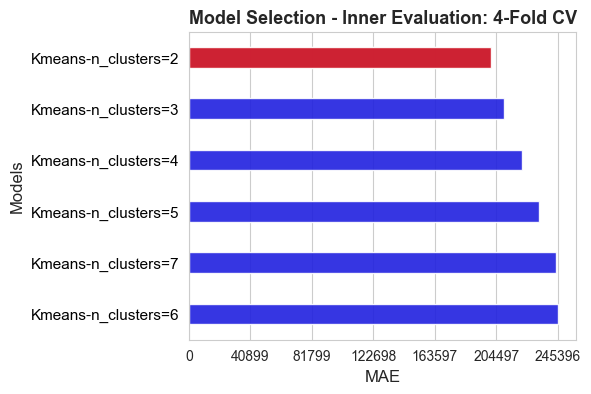

The best model among all the 6 alternatives plotted, according to the inner evaluation, is: Kmeans-n_clusters=2
MAE of the best model: 200613.991

The best model hyper-parameters are: {'preprocessing__quant__imputer__method': 'iterative_median', 'preprocessing__cat__imputer__method': 'simple_most_frequent', 'preprocessing__quant__scaler__apply': False, 'preprocessing__cat__encoder__method': 'ordinal', 'features_selector__apply': False, 'features_selector__method': nan, 'preprocessing__quant__scaler__method': nan, 'clustering_model__n_clusters': 2, 'clustering_model__estimators__0__n_estimators': 87, 'clustering_model__estimators__0__max_depth': 40.0, 'clustering_model__estimators__0__min_samples_split': 14, 'clustering_model__estimators__0__min_samples_leaf': 13, 'clustering_model__estimators__1__max_depth': 10.0, 'clustering_model__estimators__1__lambda': 0.5, 'clustering_model__estimators__1__n_estimators': 100, 'clustering_model__estimators__1__eta': 0.14, 'clustering_model__estimat

In [77]:
fig, axes = plt.subplots(figsize=(5,4))

ax = sns.barplot(y=sorted_pipelines, x=sorted_scores, color='blue', width=0.4, alpha=0.9)
ax = sns.barplot(y=[best_pipeline], x=[score_best_pipeline], color='red', width=0.4, alpha=0.9)

ax.set_ylabel('Models', size=12)
ax.set_xlabel('MAE', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(inner_score_values), 7),3)) 
ax.tick_params(axis='y', labelsize=11)    
plt.title(f'Model Selection - Inner Evaluation: 4-Fold CV', size=13, weight='bold')
for label in ax.get_yticklabels():
    label.set_color('black') 
plt.show()

print(f'The best model among all the {len(sorted_scores)} alternatives plotted, according to the inner evaluation, is: {best_pipeline}')
print('MAE of the best model:', np.round(score_best_pipeline, 3))
print('\nThe best model hyper-parameters are:', best_params_large[best_pipeline])